In [72]:
from __future__ import division, unicode_literals, print_function  # for compatibility with Python 2 and 3

import matplotlib as mpl 
import matplotlib.pyplot as plt
from matplotlib import rc
import imageio
from scipy.stats import linregress
rc('animation', html='html5')

%matplotlib inline

# Optionally, tweak styles.
mpl.rc('figure',  figsize=(5, 10))
mpl.rc('image', cmap='gray')
import numpy as np
import pandas as pd
import trackpy as tp
import seaborn as sns

from pandas import DataFrame, Series  # for convenience
import os
from ntpath import basename

import pims
import pySPM as spm 
import glob

#@pims.pipeline
#def gray(image):
#    return image[:, :, 1]  # Take just the green channel
#frames = gray(pims.open('../track_molecules/*.bmp'))

class SXMReader(pims.FramesSequence):
    def __init__(self, filename_pattern):
        #self.filenames = glob.glob(filename_pattern)
        self.filenames = filename_pattern
        self.scans = [spm.SXM(filename) for filename in self.filenames]
        self.z_data = np.array([s.get_channel("Z").correct_plane().pixels for s in self.scans]) #grab z-channel
        min_z = np.min(self.z_data)
        max_z = np.max(self.z_data)
        self.z_data -= min_z
        self.z_data /= max_z-min_z
        self._len = len(self.z_data)
        self._dtype = self.z_data.dtype
        self._frame_shape = self.z_data[0].shape
        self.scan_size = self.scans[0].size
        self.meters_per_pixel = self.scan_size['real']['x']/self.scan_size['pixels']['x']
       
    def get_frame(self, i):
        # Access the data you need and get it into a numpy array.
        # Then return a Frame like so:
        return pims.Frame(self.z_data[i], frame_no=i)

    def __len__(self):
        return self._len

    @property
    def frame_shape(self):
        return self._frame_shape

    @property
    def pixel_type(self):
        return self._dtype
    
if True:
#     sets= [range(533, 543), range(543, 553), range(553, 563), range(563, 573), range(573, 583), range(583, 593), range(593, 603)]
    #sets= [range(593, 603)]
    #sets= [range(46, 76)]
    #sets= [range(16, 46), range(46, 76), range(76, 106), range(106, 136), range(136, 166)]
    sets= [range(513, 543), range(543, 573), range(573, 603), range(603, 633), range(633, 663), range(663, 693), range(693, 723), range(723, 753), range(753, 783), range(783, 813), ]
           #range(813, 843)]
    voltage = np.arange(5.0,6.50,0.15)
    #voltages: -5, -5.15, -5.3 ... -6.5V (total 11 points)

    
    n_range = [i for i in sets]
    N = [len(i) for i in sets]
    SXM_PATH = [["electromigration_11/Image_{0:03}.sxm".format(i) for i in n_range[j]] for j in range(len(n_range))]
    molecule_size = 11
    min_mass = 1.5
    max_mass = 10
    min_size = 2
    max_ecc = 1

In [73]:
from PIL import Image

Frame 29: 12 trajectories present.


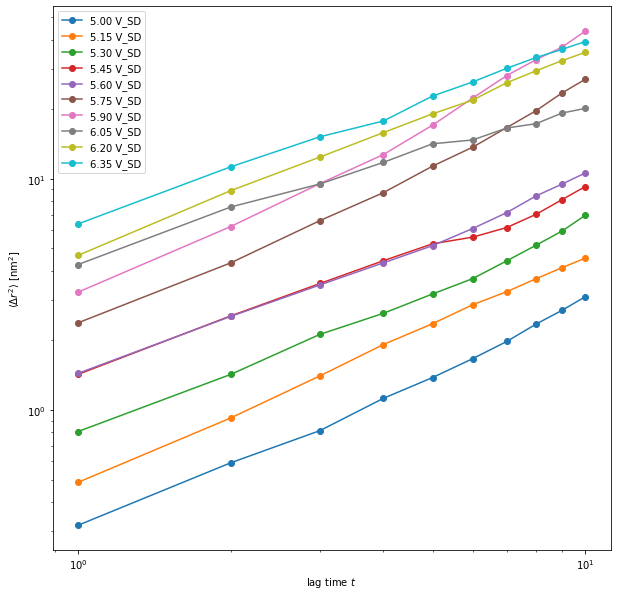

In [75]:
def is_track_good(track):
    global displacements
    x = track['x'].values
    y = track['y'].values
    denan = lambda x: x[~np.isnan(x)]
    x = denan(x) 
    y = denan(y) 
    pos = np.array([x,y]).T
    delta = pos[1:]-pos[:-1]
    mean_square = np.einsum("ij, ij->i", delta, delta)
    good = np.max(mean_square) < (10e-9/frames.meters_per_pixel)**2
    (good_particles if good else bad_particles).append(track['particle'].values[0])
    if(good):
        paths.append(delta)
    return good

powers = []
D_constants = []
indices = []
ems = []
fig, ax = plt.subplots(figsize=(10,10))
idx = 0
for path in SXM_PATH:
    frames = SXMReader(path)
#     frames_1 = [];
#     for i in range(len(frames)):
#         frames_1.append(frames[i][0:120,0:120])        
    f = tp.batch(frames[:], molecule_size, minmass=min_mass)
    t = tp.link(f, search_range=20, adaptive_stop=5, memory=3)
    t1 = t[((t['mass'] > min_mass) & (t['size'] > min_size) &
         (t['ecc'] < max_ecc)) & (t['mass'] < max_mass)]
    t2 = tp.filter_stubs(t, 1)
    d = tp.compute_drift(t2)
    t3 = tp.subtract_drift(t2.copy(), d)
    good_particles = []
    bad_particles = []
    t4 = t3.groupby('particle').filter(lambda x: len(x) >= 2)
    paths = []
    tm = t4.groupby('particle').filter(is_track_good)
    im = tp.imsd(tm, 1e6*frames.meters_per_pixel, 1)  # microns per pixel = 100/285., frames per second = 24
    
    em = tp.emsd(tm, frames.meters_per_pixel*1e9, 1, max_lagtime=10) # microns per pixel = 100/285., frames per second = 24
    ax.plot(em.index, em, 'o-', label= "{:.2f} V_SD".format(voltage[idx]))
    ax.legend()
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set(ylabel=r'$\langle \Delta r^2 \rangle$ [nm$^2$]',
    xlabel='lag time $t$')
    #ax.set(ylim=(1e-2, 10));
#     result = tp.utils.fit_powerlaw(em)  # performs linear best fit in log space, plots]
    result, _, _, _, _ = linregress(em.index, em)
#     powers.append(result['n'])
#     D_constants.append(result['A'])
    indices.append(em.index)
    ems.append(em)
    D_constants.append(result)
    idx=idx+1
    



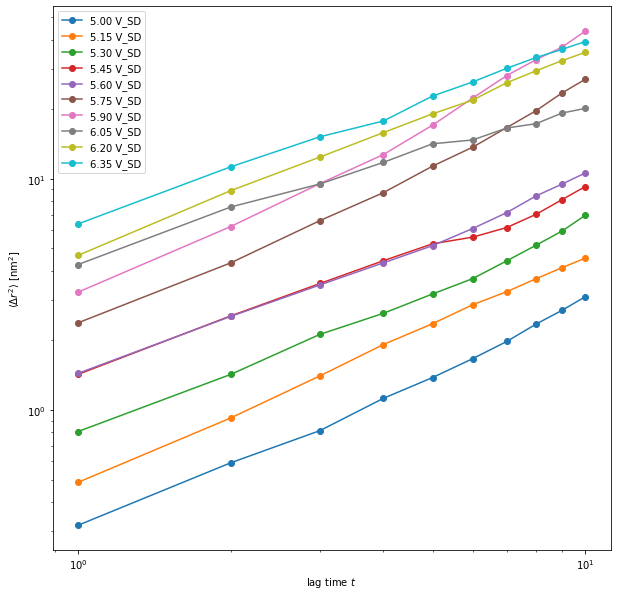

In [76]:
fig, ax = plt.subplots(figsize=(10,10))
idx = 0
for index, em in zip(indices, ems):
    ax.plot(em.index, em, 'o-', label= "{:.2f} V_SD".format(voltage[idx]))
    ax.legend()
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set(ylabel=r'$\langle \Delta r^2 \rangle$ [nm$^2$]',
       xlabel='lag time $t$')
    idx += 1

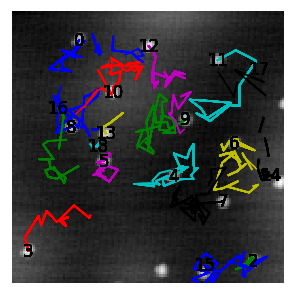

In [77]:
from IPython.display import HTML
from matplotlib.animation import FuncAnimation

fig=plt.figure(figsize=(4, 3), dpi=120)
ax1=plt.axes(xlim=(0, 256), ylim=(0, 256), frameon=False)
plt.axis('off')
ln, = ax1.plot([], [], lw=3)
ps = {'color' : 'r'}
ax1.set_prop_cycle(color=['b', 'g', 'r', 'c', 'm', 'y', 'k'])

def update(i):
    tp.plot_traj(tm[(tm['frame']<=i)], superimpose=frames[i], label=True, ax=ax1)
    ax1.set_prop_cycle(color=['b', 'g', 'r', 'c', 'm', 'y', 'k'])
    return ln,

ani = FuncAnimation(fig, update, frames=range(len(frames)))
ani

Text(0, 0.5, 'probability density')

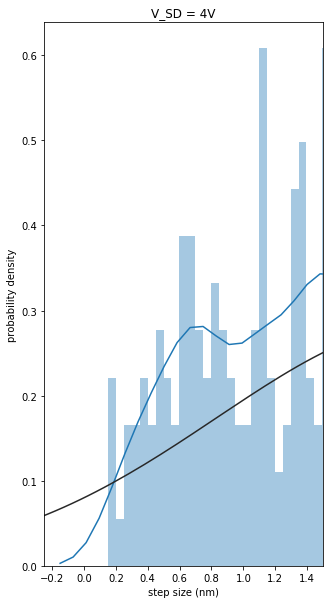

In [78]:
from scipy.stats import norm
dists = t4.groupby('particle').apply(lambda x : np.sqrt(x.x.diff() ** 2 + x.y.diff() ** 2).dropna())
sns.distplot(dists.values.flatten() * frames.meters_per_pixel*1e9, fit=norm, kde=True, bins=150, norm_hist=True, kde_kws={'bw' : 0.1})
plt.xlim(-0.25, 1.5)
plt.title('V_SD = 4V')
plt.xlabel('step size (nm)')
plt.ylabel('probability density')

In [79]:
D_constants

[0.3046833814964973,
 0.4536751267695773,
 0.6550244592097078,
 0.8039163477516921,
 1.0024239841486162,
 2.712928393307566,
 4.528188365523769,
 1.6935756478799915,
 3.3861426000018957,
 3.6567666506475347]

Text(0, 0.5, 'log Diffusion constant')

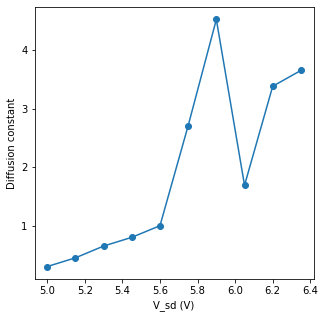

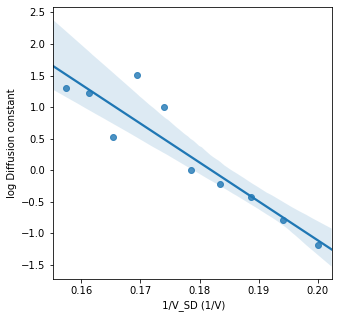

In [80]:
fig, ax = plt.subplots(figsize=(5,5))
ax.plot(voltage, D_constants, 'o-')
# ax.set_yscale('log')
plt.xlabel('V_sd (V)')
plt.ylabel('Diffusion constant')

fig, ax = plt.subplots(figsize=(5,5))
# sns.regplot(np.reciprocal(voltage), np.log(np.array(D_constants)[:,0]))
sns.regplot(np.reciprocal(voltage), np.log(D_constants))
# ax.set_yscale('log')
plt.xlabel(' 1/V_SD (1/V)')
plt.ylabel('log Diffusion constant')

# fig, ax = plt.subplots(figsize=(5,5))
# ax.plot(voltage,powers,'x-')
# plt.xlabel('V_SD (V)')
# plt.ylabel('power law')

In [81]:
D_constants

[0.3046833814964973,
 0.4536751267695773,
 0.6550244592097078,
 0.8039163477516921,
 1.0024239841486162,
 2.712928393307566,
 4.528188365523769,
 1.6935756478799915,
 3.3861426000018957,
 3.6567666506475347]

In [82]:
np.arange(2.2,4.3,0.3)

array([2.2, 2.5, 2.8, 3.1, 3.4, 3.7, 4. ])

In [83]:
result.A

AttributeError: 'numpy.float64' object has no attribute 'A'

In [ ]:
plt.figure()

for i,frame in enumerate(frames_1):
    tp.annotate(f[f['frame']==i], frame)

In [ ]:
np.size(frames_1[0],0)

In [ ]:
t = tp.link(f, search_range=50, adaptive_stop=5, memory=3)
plt.figure()
tp.mass_size(t.groupby('particle').mean()); # convenience function -- just plots size vs. mass
tp.mass_ecc(t.groupby('particle').mean()); # convenience function -- just plots size vs. mass

In [ ]:
t1 = t[((t['mass'] > min_mass) & (t['size'] > min_size) &
         (t['ecc'] < max_ecc)) & (t['mass'] < max_mass)]
t2 = tp.filter_stubs(t, 1)

# Compare the number of particles in the unfiltered and filtered data.
print('Before:', t['particle'].nunique())
print('After:', t2['particle'].nunique())

In [ ]:
for i,frame in enumerate(frames):
    fig=plt.figure()
    ax1=plt.axes(frameon=False)
    tp.plot_traj(t2[t2['frame']<=i], superimpose=frame, ax=ax1);
    plt.axis('off')
    #fig.savefig('test2/plot'+'{0:03}'.format(i)+'.png', bbox_inches='tight')

In [24]:
d = tp.compute_drift(t2)
t3 = tp.subtract_drift(t2.copy(), d)
#t3 = t2
print(d)

               y         x
frame                     
1       1.397941  1.130875
2       1.130933  1.413097
3       1.701122  2.404097
4      -0.174762  3.648431
5       0.022288  3.682928
6       0.764801  2.545185
7      -0.777394  0.766906
8      -2.172757  2.472233
9      -1.661365  4.109421
10     -6.658832  3.271287
11     -5.865006  2.293396
12     -9.361303  2.908169
13    -10.399156  3.866675
14    -10.559142  2.321309
15    -11.479534  4.603754
16    -12.950682  1.975221
17    -11.729059  1.415945
18     -9.749016  3.820918
19     -8.395375  2.688951
20     -8.750692  0.549005
21     -9.050490  0.230818
22     -9.899014  3.201208
23    -10.397406  1.729169
24    -10.635893  3.089750
25    -10.130792  3.941170
26    -11.160653  4.930207
27    -11.653898  5.430726
28    -10.551893  4.528665
29    -12.125444  3.990464


bad: [0, 1, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]


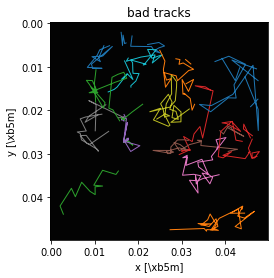

good: [2, 2]


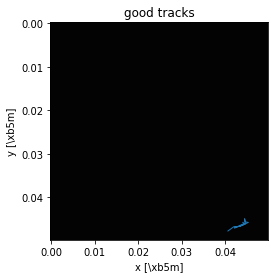

                     2
lag time [s]          
1.0           0.000003
2.0           0.000004
3.0           0.000004
4.0           0.000005
5.0           0.000004
6.0           0.000007
7.0           0.000009
8.0           0.000014
9.0           0.000019
10.0          0.000003
11.0          0.000018
12.0          0.000016


In [25]:
good_particles = []
bad_particles = []
t4 = t2.groupby('particle').filter(lambda x: len(x) >= 2)
paths = []
def is_track_good(track):
    global displacements
    x = track['x'].values
    y = track['y'].values
    denan = lambda x: x[~np.isnan(x)]
    x = denan(x) 
    y = denan(y) 
    pos = np.array([x,y]).T
    delta = pos[1:]-pos[:-1]
    mean_square = np.einsum("ij, ij->i", delta, delta)
    good = np.max(mean_square) < (3e-9/frames.meters_per_pixel)**2
    (good_particles if good else bad_particles).append(track['particle'].values[0])
    if(good):
        paths.append(delta)
    return good 
#movement_filter = t4.groupby('particle').apply(is_track_good).values
tm = t4.groupby('particle').filter(is_track_good)
print("bad:", bad_particles)
plt.figure()
plt.title("bad tracks")
tp.plot_traj(t4.groupby('particle').filter(lambda x: not is_track_good(x)), mpp=(frames.meters_per_pixel*1e6), superimpose=frames[0]);
print("good:", good_particles)
plt.title("good tracks")
tp.plot_traj(tm, mpp=(frames.meters_per_pixel*1e6), superimpose=frames[0]);
im = tp.imsd(tm, 1e6*frames.meters_per_pixel, 1)  # microns per pixel = 100/285., frames per second = 24
#im = im.T[movement_filter].T 
print(im)

The mean square displacement is:  2.876875373083918 nm


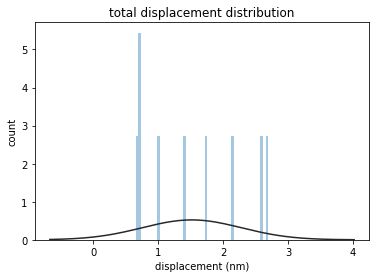

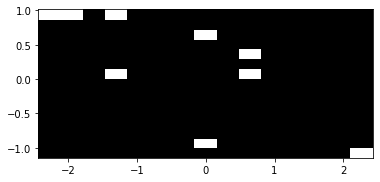

In [ ]:
from scipy.stats import norm
displacements = np.concatenate(paths)*frames.meters_per_pixel*1e9
dists = np.sqrt(np.einsum("ij, ij->i", displacements, displacements))
print("The mean square displacement is: ", (dists**2).mean(), "nm")
plt.title("total displacement distribution")
plt.xlabel("displacement (nm)")
plt.ylabel("count")
sns.distplot(dists, fit=norm, kde=False, bins=50);
fig, ax = plt.subplots()
ax.set_aspect('equal', 'box')
ax.hist2d(displacements.T[0], displacements.T[1], bins = 15);
plt.figure(figsize=(5,5));
import seaborn as sns
displacement_df = pd.DataFrame(displacements, columns=['dx','dy'])
#g = sns.jointplot(x="dx", y="dy", data=displacement_df)
plt.scatter(displacement_df['dx'],displacement_df['dy'])
plt.xlim(-0.5,0.5)
plt.ylim(-0.5,0.5)
plt.grid()
ax.set_aspect('equal', 'box')
plt.figure(figsize=(5,5));
plt.scatter(displacement_df['dx'],displacement_df['dy'])
plt.xlim(-2,2)
plt.ylim(-2,2)
plt.grid()
ax.set_aspect('equal', 'box')

In [ ]:
fig, ax = plt.subplots()
ax.plot(im.index, im, 'k-', alpha=0.1)  # black lines, semitransparent
ax.set(ylabel=r'$\langle \Delta r^2 \rangle$ [nm$^2$]',
       xlabel='lag time $t$')
#ax.set_xscale('log')
#ax.set_yscale('log')

In [ ]:
em = tp.emsd(tm, frames.meters_per_pixel*1e9, 1) # microns per pixel = 100/285., frames per second = 24
fig, ax = plt.subplots()
ax.plot(em.index, em, 'o')
#ax.set_xscale('log')
#ax.set_yscale('log')
ax.set(ylabel=r'$\langle \Delta r^2 \rangle$ [nm$^2$]',
       xlabel='lag time $t$')
#ax.set(ylim=(1e-2, 10));
fig.savefig('diffusion.png')

In [ ]:
fig=plt.figure()
plt.ylabel(r'$\langle \Delta r^2 \rangle$ [$\mu$m$^2$]')
plt.xlabel('lag time $t$');
tp.utils.fit_powerlaw(em)  # performs linear best fit in log space, plots]

In [ ]:
for i,frame in enumerate(frames):
    fig=plt.figure()
    #ax1=plt.axes(frameon=False)
    pos = t3.set_index(['frame', 'particle'])['x'].unstack()
    vh=tp.motion.vanhove(pos,i,ensemble=True)
    plt.plot(vh)
    plt.xlim(-20, 20)
    plt.ylim(0,0.4)
    #plt.axis('off')
    #fig.savefig('vanHove_'+'{0:03}'.format(i)+'.png', bbox_inches='tight')
